## ME40: Dimensional & Data Analyses in Engineering
### HW 7 - Wednesday December 3rd, 2025
#### Marissa Till

### Problem 4 - Cantilever beam (the return)
##### (This was done in Python rather than MATLAB)

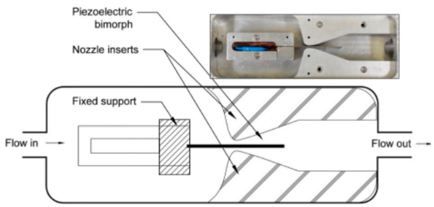

In HW6 problem 2, you investigated the oscillation of a cantilever beam located inside a converging-diverging pipe with water flowing past the beam. Feel free to read again the description of the problem. In Q6 of HW6, you were asked to estimate approximately the frequency of the oscillations.

1. Recall the frequency from your submitted HW6 set.
2. Evaluate the frequency using the fft routine from MATLAB. Compare your answers.

In [1]:
# === Import Required Packages ===
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
# === 1. Recall the frequency from HW6 Set ===

# Load the data
data = loadmat(r'/Users/marissatill/Downloads/junior year/fall/me40/sets/week 8/HW6_beam.mat')
data  = {k:v for k, v in data.items() if k[0] != '_'}
Y = pd.DataFrame(data["Y"].T)  # shape: (3500, 100)
xpos = data["xpos"]  # shape: (100, 1)
time = data["time"]  # shape: (1, 3500)

# Center the data
means = Y.mean()
Y_centered = Y - means

# Perform an economy SVD
U, S, V = np.linalg.svd(Y_centered, full_matrices=False)

# Square the singular values --> obtain variances
variances = S**2

# Extract first two spatial modes (rows of Vt)
mode1 = V[0, :]
mode2 = V[1, :]

# Normalize to L2 norm unity
mode1 /= np.linalg.norm(mode1)
mode2 /= np.linalg.norm(mode2)

# Match Matlab convention: flip sign if last entry negative
if mode2[-1] < 0:
    mode2 = -mode2

# Weights
weight1 = np.dot(Y_centered.values, mode1)
weight2 = np.dot(Y_centered.values, mode2)

# Total time
T = time[0, -1] - time[0, 0]  # seconds

def approx_freq(signal):

    crossings = []

    for i in range(len(signal) - 1):
        if signal[i] < 0 and signal[i + 1] > 0:
            crossings.append(i)

    # Approximate frequency
    freq = len(crossings) / T

    # Get difference in time between each signal crossing 0
    time_diffs = np.diff(crossings)

    # Convert indices to seconds
    time_diffs_sec = time_diffs / (len(signal) / T)

    mean_time = np.mean(time_diffs_sec)
    var_time = np.var(time_diffs_sec)

    return freq, mean_time, var_time

freq1, mean_t1, var_t1 = approx_freq(weight1)
freq2, mean_t2, var_t2 = approx_freq(weight2)

print("Approximate Frequencies:")
print(f"  Mode 1: {freq1:.2f} Hz")
print(f"  Mode 2: {freq2:.2f} Hz")

Approximate Frequencies:
  Mode 1: 50.37 Hz
  Mode 2: 51.80 Hz


FFT-based Frequencies:
   Mode 1: 50.36 Hz
   Mode 2: 50.36 Hz


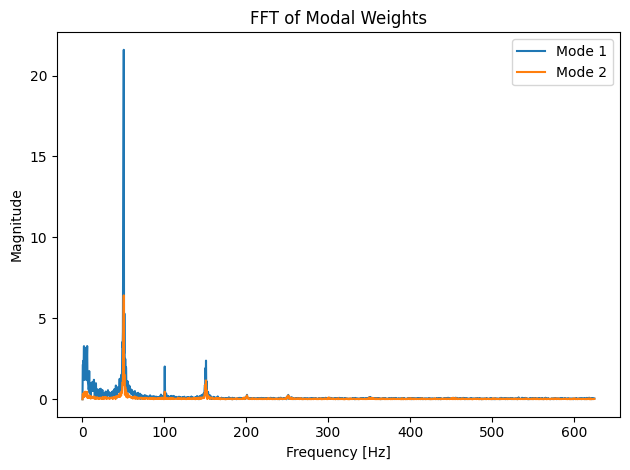

In [3]:
# === 2. Evaluate the frequency using the fft routine from MATLAB ===

dt = time[0,1] - time[0,0]   # time step
fs = 1/dt                    # sampling frequency
N = len(time[0])             # number of samples

def fft_dominant(signal):

    X = np.fft.fft(signal)  # Fourier
    mag = np.abs(X[:int(N/2)])   # Keep only positive frequencies

    freqs = np.arange(0, int(N/2)) * (fs / N)  # Normalize & divide by time period

    idx = np.argmax(mag[1:]) + 1  # Find the max frequency, ignoring the zero-frequency mean
    dom_freq = freqs[idx]

    return dom_freq, freqs, mag

f1, freqs1, mag1 = fft_dominant(weight1)
f2, freqs2, mag2 = fft_dominant(weight2)

print("FFT-based Frequencies:")
print(f"   Mode 1: {f1:.2f} Hz")
print(f"   Mode 2: {f2:.2f} Hz")

plt.figure()
plt.plot(freqs1, mag1, label='Mode 1')
plt.plot(freqs2, mag2, label='Mode 2')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('FFT of Modal Weights')
plt.legend()
plt.tight_layout()
plt.show()

The approximated frequency of mode 1 (50.37 Hz) is nearly the same as the frequency evaluated using fft (50.36 Hz). Both mode 1 and mode 2 have the same frequency when found with fft, meaning that the beam oscillates primarily at one frequency, and the first two spatial modes capture that same oscillation--just with different shapes/patterns. This is why the approximation for mode 2 may not have matched the fft evaluation as well.